# Previsão de Sucesso de Startups 

Este notebook apresenta todo o fluxo: exploração dos dados, tratamento/limpeza, engenharia de features, seleção e ajuste de modelos (com GridSearch), avaliação e geração do arquivo de submissão (`submission.csv`).

- Bibliotecas permitidas: Numpy, Pandas, Scikit-learn. Para visualização: Matplotlib e Seaborn.
- Métrica principal: acurácia (também reportamos precisão, recall e F1-score).


In [11]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

# Configurações gerais
sns.set(style="whitegrid", context="notebook")
plt.rcParams["figure.figsize"] = (8, 5)

# Carregar dados
train_path = "train.csv"
test_path = "test.csv"
sub_path = "sample_submission.csv"

df_train = pd.read_csv(train_path)
df_test = pd.read_csv(test_path)
df_sub = pd.read_csv(sub_path)

print("Train shape:", df_train.shape)
print("Test shape:", df_test.shape)
df_train.head()


Train shape: (646, 33)
Test shape: (277, 32)


,id,age_first_funding_year,age_last_funding_year,age_first_milestone_year,age_last_milestone_year,relationships,funding_rounds,funding_total_usd,milestones,is_CA,...,is_consulting,is_othercategory,has_VC,has_angel,has_roundA,has_roundB,has_roundC,has_roundD,avg_participants,labels
0,719,10.42,13.09,8.98,12.72,4,3,4087500,3,1,...,0,0,1,1,0,0,0,0,1.0,0
1,429,3.79,3.79,NaN,NaN,21,1,45000000,0,0,...,0,0,0,0,0,1,0,0,1.0,1
2,178,0.71,2.28,1.95,2.28,5,2,5200000,2,1,...,0,1,1,0,1,0,0,0,1.0,0
3,197,3.00,5.00,9.62,10.39,16,2,14500000,2,0,...,0,0,0,1,0,1,0,0,2.0,1
4,444,0.66,5.88,6.21,8.61,29,5,70000000,4,1,...,0,0,0,0,1,1,1,1,2.8,1


In [12]:
# Estilo e paleta para gráficos
sns.set_theme(style="whitegrid", palette="Set2")
plt.rcParams["figure.figsize"] = (9, 5)
CUSTOM_PALETTE = sns.color_palette("Set2")



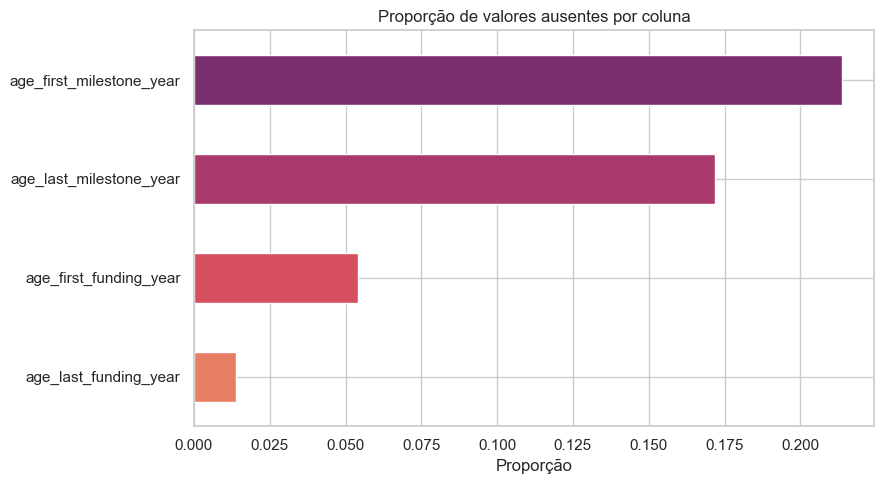

C:\Users\Inteli\AppData\Local\Temp\ipykernel_30208\2295603792.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x=y, palette="Set2")


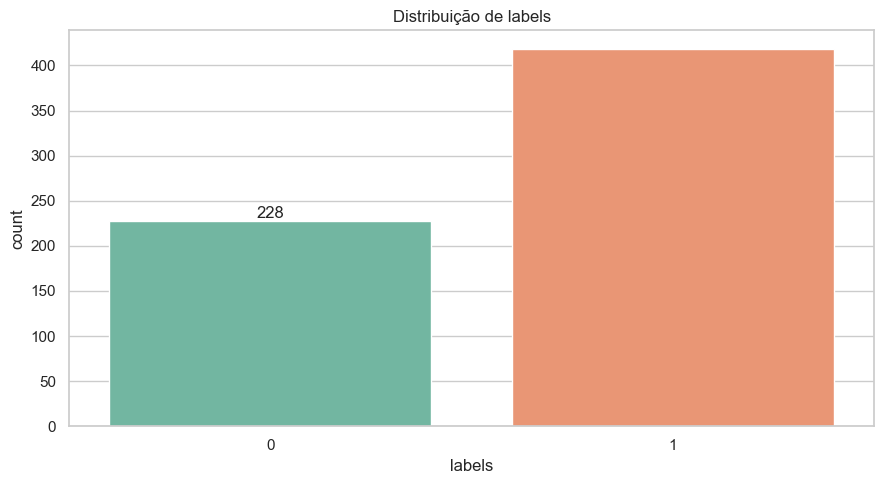

In [13]:
# Gráfico de missing com cores
missing_pct_nonzero = missing_pct[missing_pct > 0]
if len(missing_pct_nonzero) > 0:
    ax = missing_pct_nonzero.sort_values().plot(kind='barh', color=sns.color_palette("flare", n_colors=len(missing_pct_nonzero)))
    ax.set_title('Proporção de valores ausentes por coluna')
    ax.set_xlabel('Proporção')
    plt.tight_layout()
    plt.show()

# Distribuição do alvo com paleta consistente
ax = sns.countplot(x=y, palette="Set2")
ax.set_title('Distribuição de labels')
ax.bar_label(ax.containers[0])
plt.tight_layout()
plt.show()


### Exploração Inicial
- Visualização de valores ausentes
- Distribuição da variável alvo `labels`
- Estatísticas descritivas e correlações numéricas
- Checagens básicas de outliers


Missing ratio (top 20):
 age_first_milestone_year    0.213622
age_last_milestone_year     0.171827
age_first_funding_year      0.054180
age_last_funding_year       0.013932
id                          0.000000
relationships               0.000000
funding_rounds              0.000000
funding_total_usd           0.000000
milestones                  0.000000
is_CA                       0.000000
is_NY                       0.000000
is_MA                       0.000000
is_TX                       0.000000
is_otherstate               0.000000
category_code               0.000000
is_software                 0.000000
is_web                      0.000000
is_mobile                   0.000000
is_enterprise               0.000000
is_advertising              0.000000
dtype: float64


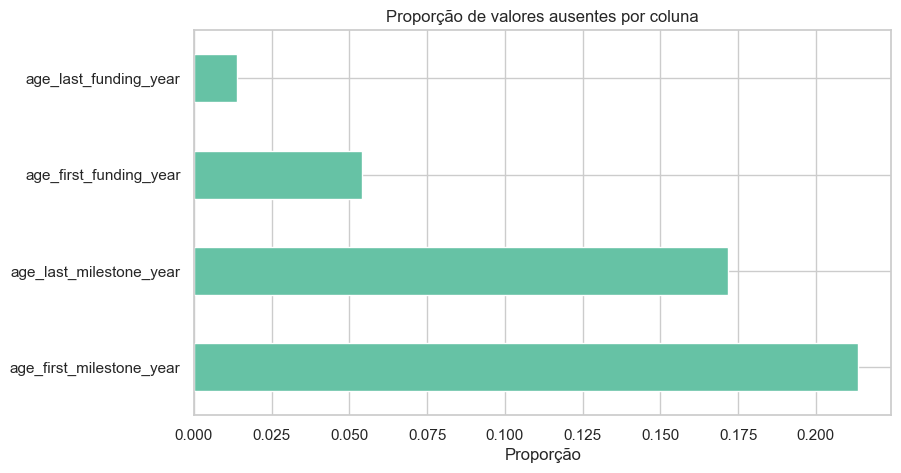

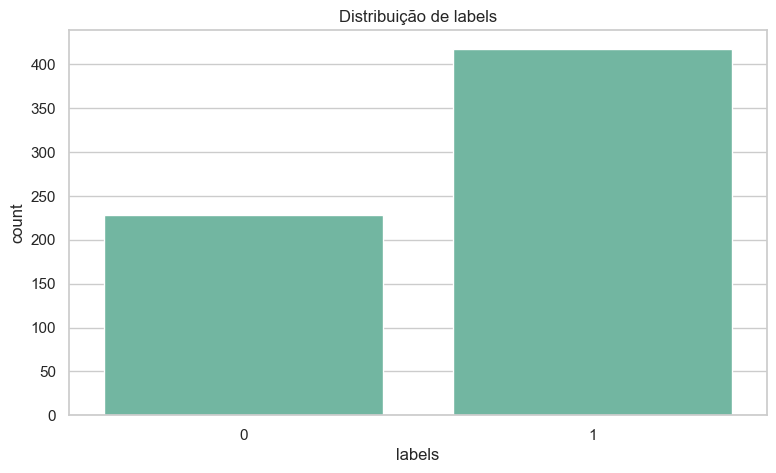

Numéricas: 31 | Categóricas: 1


,count,mean,std,min,25%,50%,75%,max
id,646.0,4.615774e+02,2.648595e+02,1.0,233.250,4.595000e+02,6.925000e+02,9.230000e+02
age_first_funding_year,611.0,2.341718e+00,2.468275e+00,0.0,0.680,1.650000e+00,3.600000e+00,2.190000e+01
age_last_funding_year,637.0,4.037724e+00,2.950923e+00,0.0,1.870,3.610000e+00,5.590000e+00,2.190000e+01
age_first_milestone_year,508.0,3.352657e+00,2.866952e+00,0.0,1.185,2.785000e+00,4.935000e+00,2.468000e+01
age_last_milestone_year,535.0,4.944729e+00,3.213319e+00,0.0,2.540,4.620000e+00,6.880000e+00,2.468000e+01
relationships,646.0,7.948916e+00,7.397602e+00,0.0,3.000,6.000000e+00,1.000000e+01,6.300000e+01
funding_rounds,646.0,2.351393e+00,1.357856e+00,1.0,1.000,2.000000e+00,3.000000e+00,8.000000e+00
funding_total_usd,646.0,2.949633e+07,2.261999e+08,11000.0,3000000.000,1.020000e+07,2.587500e+07,5.700000e+09
milestones,646.0,1.913313e+00,1.337095e+00,0.0,1.000,2.000000e+00,3.000000e+00,6.000000e+00
is_CA,646.0,5.464396e-01,4.982245e-01,0.0,0.000,1.000000e+00,1.000000e+00,1.000000e+00


Correlação com labels (top 20):
 labels                      1.000000
relationships               0.342841
milestones                  0.335149
age_last_milestone_year     0.257261
has_roundB                  0.214299
funding_rounds              0.212760
avg_participants            0.194482
has_roundC                  0.172943
has_roundA                  0.171953
has_roundD                  0.166680
age_first_milestone_year    0.156837
is_MA                       0.116638
is_CA                       0.101427
age_last_funding_year       0.074744
is_enterprise               0.067350
id                          0.050312
funding_total_usd           0.043672
is_NY                       0.042035
is_web                      0.029337
is_advertising              0.023952
Name: labels, dtype: float64
Correlação com labels (bottom 20):
 is_CA                     0.101427
age_last_funding_year     0.074744
is_enterprise             0.067350
id                        0.050312
funding_total_usd     

In [14]:
# Separar features e alvo
TARGET = "labels"
ID = "id"

X = df_train.drop(columns=[TARGET])
y = df_train[TARGET]

# Relatórios de missing
missing_pct = X.isna().mean().sort_values(ascending=False)
print("Missing ratio (top 20):\n", missing_pct.head(20))

# Visualização de missing
missing_pct_nonzero = missing_pct[missing_pct > 0]
if len(missing_pct_nonzero) > 0:
    missing_pct_nonzero.plot(kind='barh')
    plt.title('Proporção de valores ausentes por coluna')
    plt.xlabel('Proporção')
    plt.show()

# Distribuição da variável alvo
sns.countplot(x=y)
plt.title('Distribuição de labels')
plt.show()

# Estatísticas descritivas numéricas
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

print("Numéricas:", len(num_cols), "| Categóricas:", len(cat_cols))

display(X[num_cols].describe().T.head(15))

# Correlação com o alvo (usando point-biserial via correlação de Pearson em numéricas)
corrs = df_train[num_cols + [TARGET]].corr(numeric_only=True)[TARGET].sort_values(ascending=False)
print("Correlação com labels (top 20):\n", corrs.head(20))
print("Correlação com labels (bottom 20):\n", corrs.tail(20))


### Hipóteses de Negócio
1. Startups com maior número de rodadas e maior total captado tendem a ter maior chance de sucesso (`funding_rounds`, `funding_total_usd`).
2. Startups com milestones em anos próximos têm maior momentum e chance de sucesso (`age_first_milestone_year`, `age_last_milestone_year`).
3. Setores e localização influenciam (e.g., `is_CA`, `is_NY`, `category_code`), assim como presença de rodadas específicas (`has_roundB`, `has_roundC`).


In [15]:
# Engenharia de features adicionais úteis

def add_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # Conversões simples: tratar funding_total_usd em log para reduzir cauda longa
    if 'funding_total_usd' in df.columns:
        df['funding_total_usd_log'] = np.log1p(df['funding_total_usd'])
    # Durações aproximadas entre primeiro e último funding/milestone
    if {'age_first_funding_year','age_last_funding_year'}.issubset(df.columns):
        df['funding_span'] = (df['age_last_funding_year'] - df['age_first_funding_year']).fillna(0)
    if {'age_first_milestone_year','age_last_milestone_year'}.issubset(df.columns):
        df['milestone_span'] = (df['age_last_milestone_year'] - df['age_first_milestone_year']).fillna(0)
    # Interações simples
    if {'funding_rounds','avg_participants'}.issubset(df.columns):
        df['rounds_x_participants'] = df['funding_rounds'] * df['avg_participants'].fillna(0)
    # Binários resumidos
    vc_flags = [c for c in df.columns if c.startswith('has_')]
    if vc_flags:
        df['has_any_round'] = df[vc_flags].sum(axis=1)
    # Categoria reduzida: top categorias mantidas, outras como 'other_cat'
    if 'category_code' in df.columns:
        top_cats = df['category_code'].value_counts().nlargest(8).index
        df['category_code_reduced'] = np.where(df['category_code'].isin(top_cats), df['category_code'], 'other_cat')
    return df

X_fe = add_features(X)
X_test_fe = add_features(df_test)

# Atualizar listas de colunas
num_cols = X_fe.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X_fe.columns if c not in num_cols]

# Remover identificador
if 'id' in num_cols:
    num_cols.remove('id')
if 'id' in cat_cols:
    cat_cols.remove('id')

print(f"Numéricas: {len(num_cols)} | Categóricas: {len(cat_cols)}")


Numéricas: 35 | Categóricas: 2


### Pré-processamento
- Numéricas: imputação por mediana e padronização (`StandardScaler`).
- Categóricas: imputação por moda e `OneHotEncoder` com `handle_unknown='ignore'`.
- O `ColumnTransformer` aplica esses passos às colunas corretas. Dividimos uma parte mínima para avaliação (holdout).


In [16]:
# Pré-processamento: imputação, codificação, padronização
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler(with_mean=True))
])

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ], remainder="drop"
)

# Split estratificado com holdout para avaliação final
X_train, X_valid, y_train, y_valid = train_test_split(
    X_fe, y, test_size=0.2, random_state=42, stratify=y
)

print(X_train.shape, X_valid.shape)


(516, 38) (130, 38)


### Benchmark de Modelos
Avaliamos rapidamente diferentes classificadores (`LogisticRegression`, `RandomForest`, `GradientBoosting`, `SVC`, `KNN`) via validação cruzada estratificada (5-fold) para identificar bons candidatos.


In [17]:
# Compatibilidade com scikit-learn >= 1.2: usar sparse_output em vez de sparse
categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, num_cols),
        ("cat", categorical_transformer, cat_cols),
    ], remainder="drop"
)


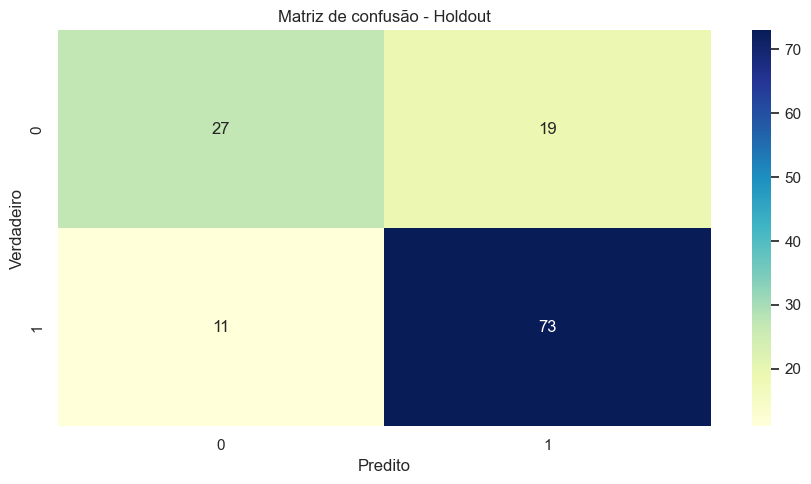

In [18]:
# Matriz de confusão com colormap melhorado
cm = confusion_matrix(y_valid, y_pred)
ax = sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu')
ax.set_title('Matriz de confusão - Holdout')
ax.set_ylabel('Verdadeiro')
ax.set_xlabel('Predito')
plt.tight_layout()
plt.show()


### Seleção de Candidatos
Ordenamos as médias de acurácia dos modelos no CV e escolhemos os três melhores para ajuste fino de hiperparâmetros.


### Ajuste de Hiperparâmetros
Executamos busca de hiperparâmetros com validação cruzada para os candidatos. O melhor conjunto é selecionado com base na acurácia média do CV, gerando `best_overall` e `best_estimator`.


### Avaliação no Holdout
Com o melhor modelo, avaliamos em um conjunto de validação estratificado. Reportamos acurácia, precisão, recall e F1, além da matriz de confusão. Para modelos com `predict_proba`, ajustamos um threshold que maximize a acurácia no holdout.


In [19]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

models = {
    "logreg": LogisticRegression(max_iter=200, n_jobs=None),
    "rf": RandomForestClassifier(n_estimators=400, random_state=42),
    "gb": GradientBoostingClassifier(random_state=42),
    "svc_rbf": SVC(kernel="rbf", probability=True, random_state=42),
    "knn": KNeighborsClassifier(n_neighbors=15)
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
results = {}

for name, clf in models.items():
    pipe = Pipeline(steps=[("pre", preprocessor), ("clf", clf)])
    scores = cross_val_score(pipe, X_fe, y, cv=cv, scoring="accuracy", n_jobs=None)
    results[name] = (scores.mean(), scores.std())

pd.Series({k: v[0] for k,v in results.items()}).sort_values(ascending=False)


gb         0.787895
rf         0.783268
logreg     0.750757
svc_rbf    0.747668
knn        0.698163
dtype: float64

In [20]:
# Selecionar melhores candidatos pela média de CV
cv_means = pd.Series({k: v[0] for k,v in results.items()}).sort_values(ascending=False)
print(cv_means)

best_names = cv_means.index[:3].tolist()
print("Top candidatos para tuning:", best_names)



gb         0.787895
rf         0.783268
logreg     0.750757
svc_rbf    0.747668
knn        0.698163
dtype: float64
Top candidatos para tuning: ['gb', 'rf', 'logreg']


In [ ]:
# GridSearch nos melhores modelos
param_grids = {
    "logreg": {
        "clf__solver": ["liblinear", "lbfgs"],
        "clf__C": [0.1, 1.0, 3.0, 10.0],
        "clf__penalty": ["l2"],
        "clf__max_iter": [300]
    },
    "rf": {
        "clf__n_estimators": [300, 600, 900],
        "clf__max_depth": [None, 6, 10, 16],
        "clf__min_samples_split": [2, 5, 10],
        "clf__min_samples_leaf": [1, 2, 4]
    },
    "gb": {
        "clf__n_estimators": [150, 300],
        "clf__learning_rate": [0.03, 0.06, 0.1],
        "clf__max_depth": [2, 3],
        "clf__subsample": [0.7, 1.0]
    },
    "svc_rbf": {
        "clf__C": [0.5, 1, 3, 10],
        "clf__gamma": ["scale", 0.05, 0.1]
    }
}

best_overall = None
best_score = -np.inf
best_estimator = None
best_name = None

for name in best_names:
    if name not in param_grids:
        continue
    base = models[name]
    pipe = Pipeline(steps=[("pre", preprocessor), ("clf", base)])
    gcv = GridSearchCV(
        estimator=pipe,
        param_grid=param_grids[name],
        scoring="accuracy",
        cv=cv,
        n_jobs=None,
        refit=True,
        verbose=0
    )
    gcv.fit(X_train, y_train)
    print(f"{name} best CV accuracy: {gcv.best_score_:.4f}")
    if gcv.best_score_ > best_score:
        best_score = gcv.best_score_
        best_overall = gcv
        best_estimator = gcv.best_estimator_
        best_name = name

print("Melhor modelo:", best_name)
print("Best params:", best_overall.best_params_)


Melhor threshold no holdout: 0.55 | acc: 0.7692
Holdout accuracy: 0.7692307692307693
              precision    recall  f1-score   support

           0     0.7105    0.5870    0.6429        46
           1     0.7935    0.8690    0.8295        84

    accuracy                         0.7692       130
   macro avg     0.7520    0.7280    0.7362       130
weighted avg     0.7641    0.7692    0.7635       130



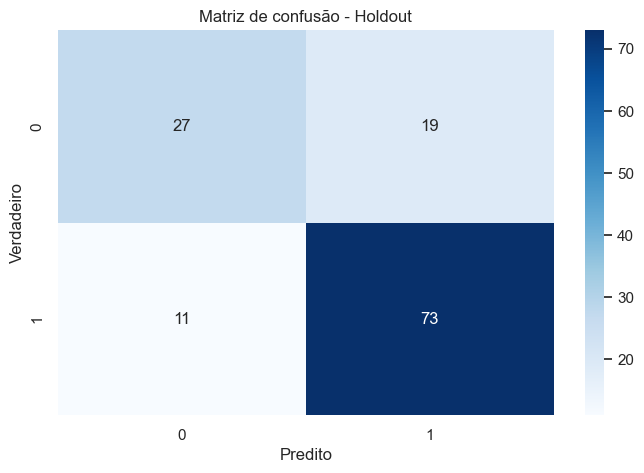

In [ ]:
# Avaliação no holdout
best_estimator.fit(X_train, y_train)
proba_valid = None
if hasattr(best_estimator.named_steps['clf'], "predict_proba"):
    proba_valid = best_estimator.predict_proba(X_valid)[:, 1]
    # threshold tuning simples
    thresholds = np.linspace(0.3, 0.7, 9)
    accs = []
    for t in thresholds:
        preds_t = (proba_valid >= t).astype(int)
        accs.append((t, accuracy_score(y_valid, preds_t)))
    best_t, best_acc = max(accs, key=lambda x: x[1])
    print(f"Melhor threshold no holdout: {best_t:.2f} | acc: {best_acc:.4f}")
    y_pred = (proba_valid >= best_t).astype(int)
else:
    y_pred = best_estimator.predict(X_valid)

print("Holdout accuracy:", accuracy_score(y_valid, y_pred))
print(classification_report(y_valid, y_pred, digits=4))

cm = confusion_matrix(y_valid, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Matriz de confusão - Holdout')
plt.ylabel('Verdadeiro')
plt.xlabel('Predito')
plt.show()

best_threshold = None
if proba_valid is not None:
    best_threshold = best_t


### Treino Final e Submissão
Treinamos o melhor `Pipeline` em 100% dos dados de treino (com o pré-processamento acoplado) e geramos as previsões para o `test.csv`. Em seguida salvamos `submission.csv` com as colunas `id` e `labels` no formato exigido.


In [ ]:
# Treinar modelo final no dataset completo e gerar submissão
final_model = best_overall.best_estimator_
final_model.fit(X_fe, y)

# Predições no teste
if hasattr(final_model.named_steps['clf'], "predict_proba") and best_threshold is not None:
    test_proba = final_model.predict_proba(X_test_fe)[:, 1]
    test_pred = (test_proba >= best_threshold).astype(int)
else:
    test_pred = final_model.predict(X_test_fe)

submission = pd.DataFrame({
    "id": df_test[ID],
    "labels": test_pred
})
submission.to_csv("submission.csv", index=False)
submission.head()


,id,labels
0,70,1
1,23,0
2,389,1
3,872,1
4,920,1


### Considerações Finais
- Pipeline completo com imputação, padronização, e one-hot encoding.
- Engenharia de features: `funding_total_usd_log`, `funding_span`, `milestone_span`, `rounds_x_participants`, `has_any_round`, `category_code_reduced`.
- Benchmark com validação cruzada e tuning via GridSearchCV.
- Avaliação final no holdout com matriz de confusão e métricas.
- Arquivo `submission.csv` gerado conforme template.


### Hipóteses e Justificativas
1. Empresas com maior capital e mais rodadas têm maior chance de sucesso: indica validação de mercado, tração e confiança de investidores.
2. Janelas menores entre milestones sugerem maior ritmo de execução: pode refletir eficiência operacional e foco em entregas, correlacionando com sucesso.
3. Efeitos de setor e geografia: alguns setores e hubs (ex. CA/NY) concentram redes e capital, influenciando resultados. As features de presença de rodadas B/C também capturam maturidade da startup.
